In [512]:
#CELL 1
#Imports necessary to run this

import numpy as np
import glob
import matplotlib.pyplot as plt

import cv2
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label
import collections


%matplotlib inline


#from scipy.optimize import linear_sum_assignment
#import itertools
#import functools

#from sklearn.externals import joblib


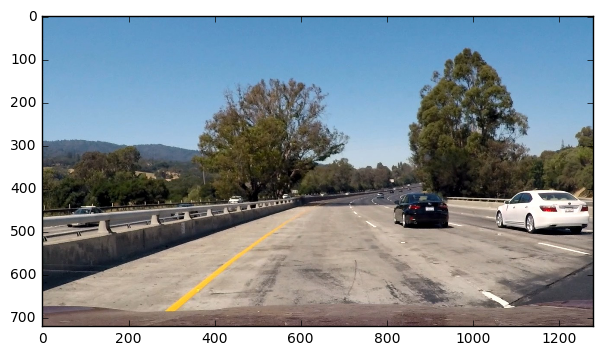

In [668]:
#CELL 2
# Reading the test images where we'll be testing the detection
imgpath = './test_images/test*.jpg'
im_paths = glob.glob(imgpath)
test_image = mpimg.imread(im_paths[0])

plt.figure(figsize=(8,4))
plt.imshow(test_image)

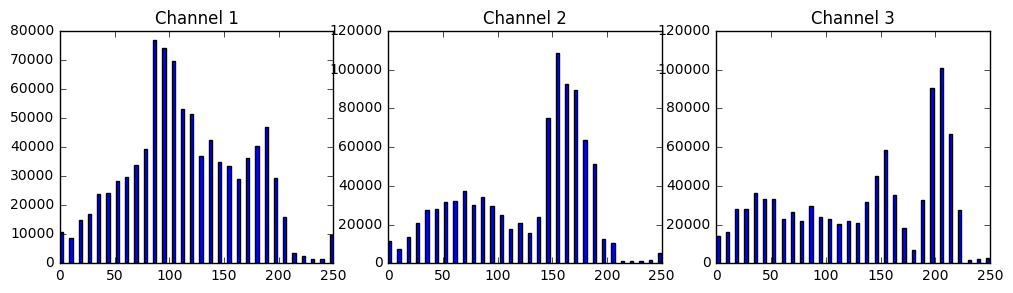

In [669]:
#CELL 3
##we start feature extraction here
## define function that takes in an image and returns color histogram features
## shows visualization of each channel if param verbose set to True

def histogram(image, bins = 30, verbose=False):
    ch1 = np.histogram(image[:,:,0], bins=bins)
    ch2 = np.histogram(image[:,:,1], bins=bins)
    ch3 = np.histogram(image[:,:,2], bins=bins)
    
    if verbose:
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3))
        ax1.bar(ch1[1][:-1],ch1[0], width=3)
        ax1.set_title("Channel 1")
        ax2.bar(ch2[1][:-1],ch2[0], width=3)
        ax2.set_title("Channel 2")
        ax3.bar(ch3[1][:-1],ch3[0], width=3)
        ax3.set_title("Channel 3")
    
    # Join all 3 histograms along the existing axis
    result = np.concatenate((ch1[0],ch2[0],ch3[0]))
    
    return result

#a visualization of the histograms for the test image
h = histogram(test_image, verbose=True)



    



In [631]:
#CELL 4
## feature extraction continued
##define function that takes in an image and returns HOG features
## verbose is used as flag to receive also visualization of the HOG features

def hogify(image, verbose=False, orientations = 9, ppc = 8, cpb = 2):
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    
    if verbose:
        
       
        hog_features, hog_image = hog(image[:,:,0], orientations=orientations,
                                      pixels_per_cell=(ppc, ppc),
                                      cells_per_block=(cpb, cpb),
                                      transform_sqrt=True,
                                      visualise=True, feature_vector=True)
        return hog_features, hog_image
    
    else:
        hog_features_ch1 = hog(image[:,:,0], orientations=orientations,
                                      pixels_per_cell=(ppc, ppc),
                                      cells_per_block=(cpb, cpb),
                                      transform_sqrt=True,
                                      visualise=False, feature_vector=True)
        hog_features_ch2 = hog(image[:,:,1], orientations=orientations,
                                      pixels_per_cell=(ppc, ppc),
                                      cells_per_block=(cpb, cpb),
                                      transform_sqrt=True,
                                      visualise=False, feature_vector=True)
        hog_features_ch3 = hog(image[:,:,2], orientations=orientations,
                                      pixels_per_cell=(ppc, ppc),
                                      cells_per_block=(cpb, cpb),
                                      transform_sqrt=True,
                                      visualise=False, feature_vector=True)
        hog_features = np.concatenate((hog_features_ch1,hog_features_ch2,hog_features_ch3))
        return hog_features



<class 'numpy.ndarray'>
(509436,)


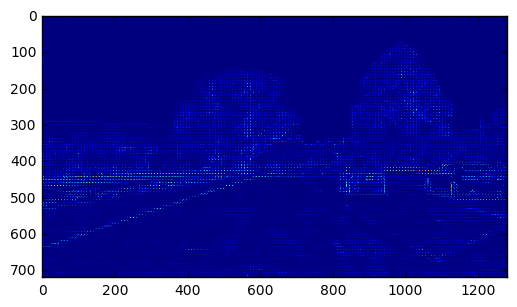

In [670]:
#CELL 5
# testing the newly written hog extract on the test image. Not really representative, as I will run this on windows only in the production pipeline
f, i = hogify(test_image, verbose = True)
print(type(i))
plt.imshow(i)
print(np.shape(f))

In [633]:
#CELL 6
#normalize the image

def normalize(image):
    return image / 255 * 0.8 + 0.1


In [634]:
#CELL 7
# Extract features from a list of images
# Allows to combine various features, although I only use HOG in this implementation

def get_features(image):
    
    image_features = []

    image = normalize(image)

    hog_features = hogify(image)
    #image_features.append(hog_features)

    #color_features = histogram(image)
    #image_features.append(color_features)
    
    #image_features = np.concatenate(hog_features,color_features)
        
    return hog_features

In [635]:
#CELL 8
## Get features out of the whole training set

#Load the training images

vehicles = glob.glob('./project_images/vehicles/*/*.png')
nonvehicles = glob.glob('./project_images/non-vehicles/*/*.png')

#Extract vehicle features
vehicle_features = []
for path in vehicles:
    image = mpimg.imread(path)
    image_features = get_features(image)
    vehicle_features.append(image_features)

#Extract non-vehicle features
nonvehicle_features = []
for path in nonvehicles:
    image = mpimg.imread(path)
    image_features = get_features(image)
    nonvehicle_features.append(image_features)






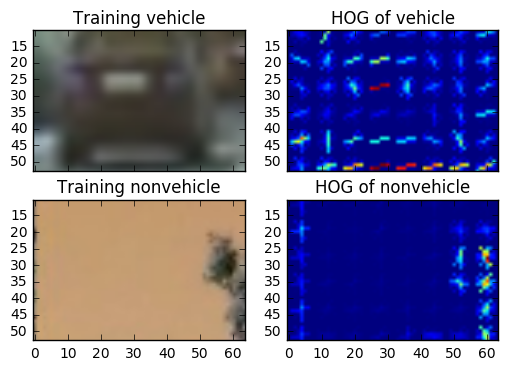

In [636]:
#The hogify / get_features function can be tested on selected vehicle and non-vehicle images

test_vehicle =cv2.imread(vehicles[0])
test_nonvehicle =cv2.imread(nonvehicles[0])
test_hog_v, i = hogify(test_vehicle, verbose = True)
test_hog_nv, j = hogify(test_nonvehicle, verbose = True)

f, ((s1, s2),(s3,s4)) = plt.subplots(2,2,sharex = True)
s1.imshow(test_vehicle)
s1.set_title("Training vehicle")
s2.imshow(i)
s2.set_title("HOG of vehicle")
s3.imshow(test_nonvehicle)
s3.set_title("Training nonvehicle")
s4.imshow(j)
s4.set_title("HOG of nonvehicle")

In [637]:
#CELL 9
#Print the shape of the feature arrays to make sure they're not empty
print(np.shape(vehicle_features))
print(np.shape(nonvehicle_features))

(10130, 5292)
(9909, 5292)


In [638]:
#CELL 10
#Construct X and y to feed the classifier
X = np.concatenate((vehicle_features, nonvehicle_features))
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))
print('Y len: ',len(y))
print('X len: ',len(X))

Y len:  20039
X len:  20039


In [639]:
#CELL 11
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [640]:
#CELL 12
#Check the shape of the training set to make sure all features are as expected
print('Len of train X: ',np.shape(X_train))
print('Len of train Y: ',np.shape(y_train))

Len of train X:  (16031, 5292)
Len of train Y:  (16031,)


In [641]:
#CELL 13
#Initialize and train the classifier, then test with the test data and report score
classifier = LinearSVC()
classifier.fit(X_train, y_train)
print("Classifier trained")
score = round(classifier.score(X_test, y_test), 3)
print("Accuracy: ", score)

Classifier trained
Accuracy:  0.97


In [642]:
#CELL 14
# Adopted from Udacity classroom
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[400, None], y_start_stop=[350, None], 
    #Use 450, None and 350, 700 for video pipeline
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [675]:
#CELL 15

# From Udacity classroom
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())

def search_windows(img, windows, clf=classifier, scaler=None, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
            
        #4) Extract features for that window 

        features = get_features(test_img)
        
        
        #6) Predict using your classifier
        #Using .decision_function for more flexibility
        res = clf.decision_function(features)
        prediction = int(res > 0.5)
        #prediction = clf.predict(features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            #print(res) # for debugging purposes
    #8) Return windows for positive detections
    return on_windows

260
[((1008, 414), (1072, 478)), ((1072, 414), (1136, 478)), ((1136, 414), (1200, 478)), ((880, 446), (944, 510))]


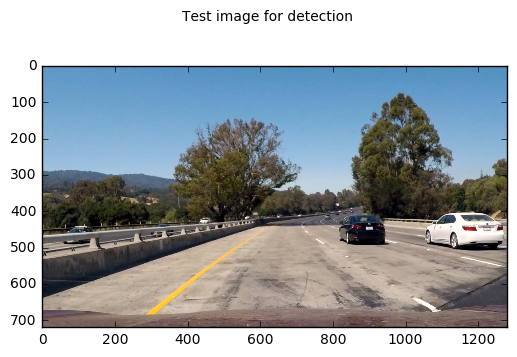

In [685]:
#CELL 16
# Testing the helper functions defined above on the test image. 
#Here we display the image, and report number of windows searched, as well as hot windows identified
rescaled_image = test_image.astype(np.float32)/255
plt.imshow(rescaled_image)
plt.suptitle("Test image for detection")
windows = slide_window(rescaled_image)
on_windows = search_windows(rescaled_image,windows)

print(len(windows))
print(on_windows)



In [677]:
#CELL 17
#Coordinates for hot windows
print(on_windows)

[((1008, 414), (1072, 478)), ((1072, 414), (1136, 478)), ((1136, 414), (1200, 478)), ((880, 446), (944, 510))]


In [678]:
#CELL 18
#From Udacity classroom
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 255, 100), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

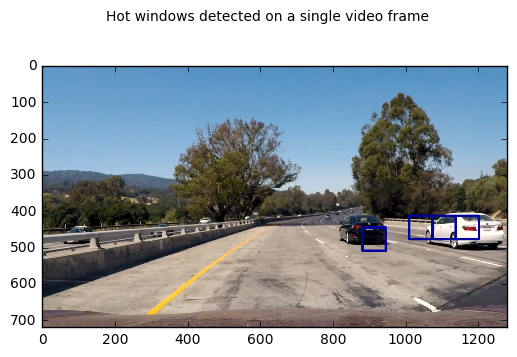

In [679]:
#CELL 19
# Testing the drawing of boxes on the test_image
test_image_w = draw_boxes(rescaled_image, on_windows)
plt.imshow(test_image_w)
plt.suptitle("Hot windows detected on a single video frame")

In [653]:
#CELL 20
# Helper functions adopted from Udacity's class code
def add_bboxes(input_image, windows, classifier=classifier, scaler=None, draw=True, bboxes_only=False):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """
    global bboxes_list
    
    # Normalise image
    # input_image = normalise(input_image)
    
    hot_windows = search_windows(input_image, windows)
   
    bboxes_list.append(hot_windows)
    
    
def apply_threshold(heatmap, threshold):
    """Returns heatmap with false positives removed."""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `bbox_list` added to it.
    `bbox_list` is an array of boxes.

    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def draw_labeled_bboxes(img, labels):
    """Return image with bounding boxes drawn around the labelled regions.
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [713]:
#CELL 21
#Pipeline to take all the necessary steps for a single image
#IN: Image
#OUT: Image with bounding boxes drawn around presumed cars, deduped using simple threshold function
def single_image_pipeline(image):
    rescaled_image = image.astype(np.float32)/255
    on_windows = search_windows(rescaled_image,windows)
    test_image_w = draw_boxes(rescaled_image, on_windows)
    heatmap = np.zeros_like(image[:,:,0])
    heatmap = add_heat(heatmap, on_windows)
    heatmap = apply_threshold(heatmap, 0.9)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img
    

    

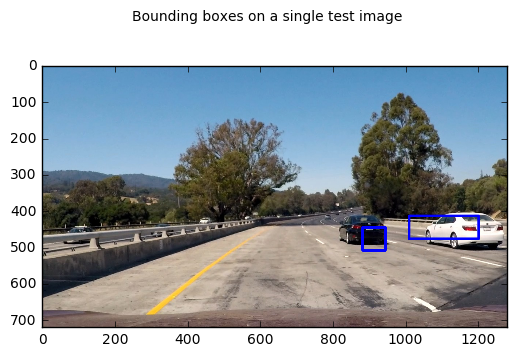

In [716]:
#CELL 22
# Testing the single image pipeline
plt.imshow(single_image_pipeline(test_image), cmap='gray')
plt.suptitle("Bounding boxes on a single test image")

In [690]:
##CELL 23
## Function to capture additional frames from the video to help train the classifier
## Adopted from single image pipeline, but saves frames to file
from datetime import datetime

def frame_capture_pipeline(image):
    rescaled_image = image.astype(np.float32)/255
    on_windows = search_windows(rescaled_image,windows)
    
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    #return draw_img
    
    for window in on_windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite("./frames/frame%s.png" % str(datetime.now()), test_img)
        print("on_window detected. Writing to file.")

    return image

## Helper to capture video frames. Used for the writeup only, to demonstrate intermediate steps of the pipeline
def full_frame_capture_pipeline(image):
    
    test_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("./frames/frame%s.jpg" % str(datetime.now()), test_img)
    print("writing frame")

    return image



In [657]:
#CELL 24
# Function that allows to average the detection for several frames, by caching the heatmaps from previous frames

def video_pipeline(image, cache, threshold = 7):
    
    # Using a dict called 'cache' to create a deque as a convenient way of managing the deck of heatmaps
    # If none yet exists, and empty is created
    if cache['heatmaps'] is None:
        cache['heatmaps'] = collections.deque(maxlen=30)
        
    
    rescaled_image = image.astype(np.float32)/255
    on_windows = search_windows(rescaled_image,windows)
    
    #Heatmap created for a single frame
    heatmap = np.zeros_like(image[:,:,0])
    heatmap = add_heat(heatmap, on_windows)
    
    #Heatmap added to the cache
    cache['heatmaps'].append(heatmap)
    #print(len(cache['heatmaps'])) #debugging only
    
    #Aggregate, thresholded heatmap is created
    thresh_heatmap = sum(cache['heatmaps'])
    thresh_heatmap[thresh_heatmap < threshold] = 0
    cv2.GaussianBlur(thresh_heatmap, (31,31), 0, dst=thresh_heatmap)
    
    #Label func is called to identify number and position of presumed cars
    labels = label(thresh_heatmap)
    
    #Call to get the bounding boxes drawn on the original image, before it's returned to the video pipeline
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    
    
    
    
    

In [608]:
##Piping it all together in preparation for the video processing
def pipeline(image):
    global cache
    
    return video_pipeline(image, cache)

In [700]:
## Video processing snippet
from moviepy.editor import VideoFileClip
from IPython.display import HTML

global cache

cache = {'heatmaps' : None}

video = VideoFileClip("./test_video.mp4")
project_clip = video.fl_image(full_frame_capture_pipeline) #NOTE: this function expects color images!!
video_output = "test.mp4"
%time project_clip.write_videofile(video_output, audio=False)


writing frame
[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


  8%|▊         | 3/39 [00:00<00:01, 20.83it/s]

writing frame
writing frame
writing frame
writing frame


 18%|█▊        | 7/39 [00:00<00:01, 19.30it/s]

writing frame
writing frame
writing frame
writing frame


 28%|██▊       | 11/39 [00:00<00:01, 17.88it/s]

writing frame
writing frame
writing frame
writing frame
writing frame


 36%|███▌      | 14/39 [00:00<00:01, 18.43it/s]

writing frame
writing frame
writing frame


 41%|████      | 16/39 [00:00<00:01, 18.48it/s]

writing frame


 49%|████▊     | 19/39 [00:01<00:01, 18.31it/s]

writing frame
writing frame
writing frame


 54%|█████▍    | 21/39 [00:01<00:01, 16.08it/s]

writing frame
writing frame


 59%|█████▉    | 23/39 [00:01<00:01, 14.89it/s]

writing frame


 64%|██████▍   | 25/39 [00:01<00:00, 14.94it/s]

writing frame
writing frame
writing frame


 69%|██████▉   | 27/39 [00:01<00:00, 15.24it/s]

writing frame


 74%|███████▍  | 29/39 [00:01<00:00, 15.88it/s]

writing frame
writing frame
writing frame


 79%|███████▉  | 31/39 [00:01<00:00, 13.91it/s]

writing frame
writing frame
writing frame


 87%|████████▋ | 34/39 [00:02<00:00, 15.75it/s]

writing frame
writing frame


 92%|█████████▏| 36/39 [00:02<00:00, 15.99it/s]

writing frame
writing frame


 97%|█████████▋| 38/39 [00:02<00:00, 16.86it/s]

writing frame


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 1.49 s, sys: 350 ms, total: 1.84 s
Wall time: 4.05 s
